In [1]:
!pip install yfinance
!pip install newsapi-python
!pip install pmdarima
!pip install visualize
!pip install pmdarima --user

In [2]:
import yfinance as yf
from statsmodels.tsa.arima_model import ARIMA
from newsapi import NewsApiClient
import pandas as pd
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn import linear_model
import numpy as np
import math
from sklearn.metrics import mean_squared_error

# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
def plot_basic(stocks, title='Close Price', y_label='Price USD', x_label='Trading Days'):
    fig, ax = plt.subplots()
    ax.plot(stocks['Close'], '#0A7388')
    ax.set_title(title)
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    plt.show()
    
def plot_prediction(actual, prediction, title='Yahoo Finance vs Prediction', y_label='Price USD', x_label='Trading Days'):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    # Add labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    # Plot actual and predicted close values
    plt.plot(actual, '#00FF00', label='Adjusted Close')
    plt.plot(prediction, '#0000FF', label='Predicted Close')
    # Set title
    ax.set_title(title)
    ax.legend(loc='upper left')
    plt.show()


In [4]:
#### GET STOCK DATA using TICKER YAHOO FINANCE API ####
def get_data_stock(stock_ticker,start_dt,end_dt):

    #define the ticker symbol
    tickerSymbol = stock_ticker

    #get data on this ticker
    tickerData = yf.Ticker(tickerSymbol)

    #get the historical prices for this ticker
    tickerDf = tickerData.history(period='1d', start=start_dt, end=end_dt)

    #see your data
    tickerDf['Item'] = np.arange(len(tickerDf))
    return tickerDf[['Item','Open', 'Close', 'Volume']]

#### GET NEWS from NEWS API #####
### API KEY : 0b2277b448e44ddbbdb1e4b45dcb8f64 ###

def get_news(stock_ticker):
    api = NewsApiClient(api_key='0b2277b448e44ddbbdb1e4b45dcb8f64')
    j = api.get_everything(q=stock_ticker)
    return j

def get_news_content(stock_ticker):
    news = get_news(stock_ticker)
    for i in news['articles']:
        print(i['title'])



In [5]:
##### Function to normalize the data features ####
def get_normalised_data(data):
    # Initialize a scaler, then apply it to the features
    scaler = MinMaxScaler()
    numerical = ['Open', 'Close', 'Volume']
    data[numerical] = scaler.fit_transform(data[numerical])
    return data

In [6]:
##### GET RMSE ######
def get_rmse(actual,predicted):
    return math.sqrt(mean_squared_error(actual,predicted))

In [7]:
### SCALING DATA ###
def scale_range(x, input_range, target_range):
    range = [np.amin(x), np.amax(x)]
    x_std = (x - input_range[0]) / (1.0*(input_range[1] - input_range[0]))
    x_scaled = x_std * (1.0*(target_range[1] - target_range[0])) + target_range[0]
    return x_scaled, range

In [20]:
####### START HERE ###
###############################

### SET THE VARIABLES TO extract Data #####
stock_ticker = 'AMZN'
start_dt = '2010-01-01'
end_dt = '2021-10-01'

### GET TICKER DATA ###
df_stock = get_data_stock(stock_ticker,start_dt,end_dt);
print(df_stock)

            Item         Open        Close    Volume
Date                                                
2010-01-04     0   136.250000   133.899994   7599900
2010-01-05     1   133.429993   134.690002   8851900
2010-01-06     2   134.600006   132.250000   7178800
2010-01-07     3   132.009995   130.000000  11030200
2010-01-08     4   130.559998   133.520004   9830500
...          ...          ...          ...       ...
2021-09-24  2952  3402.010010  3425.520020   2116200
2021-09-27  2953  3371.500000  3405.800049   3634500
2021-09-28  2954  3357.709961  3315.959961   4430800
2021-09-29  2955  3322.110107  3301.120117   2562300
2021-09-30  2956  3316.000000  3285.040039   2842400

[2957 rows x 4 columns]


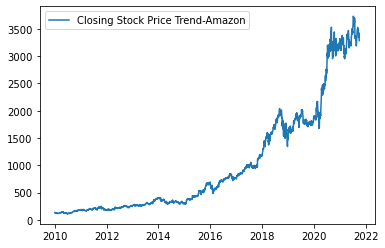

In [131]:
from matplotlib import pyplot as plt
ts=df_stock["Close"]
#acf -> remove trend
df_stock["diff"] = df_stock["Close"].diff()
df_stock["diff"].iloc[0] = 0
plt.plot(df_stock["Close"], label='Closing Stock Price Trend-Amazon')
plt.legend(loc='best')

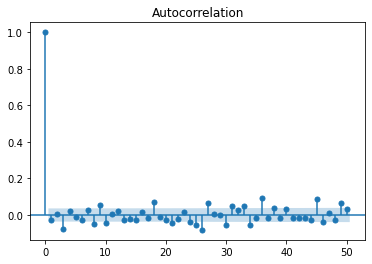

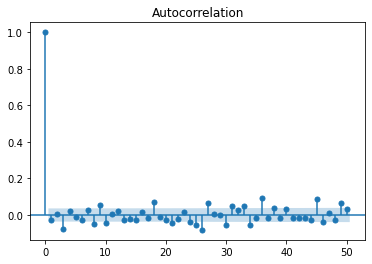

In [132]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_acf to identify the value of q
# Q: Seasonal moving average order
plot_acf(df_stock["diff"],lags=50)
#plot_acf(df_stock["Close"])

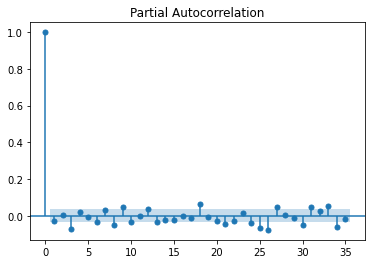

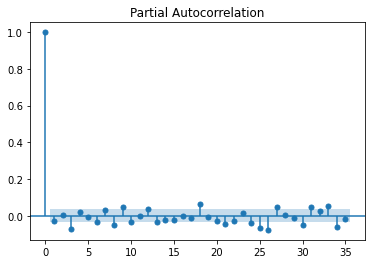

In [105]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# plot_pacf to identify the value of p
# P: Seasonal Autoregressive order
plot_pacf(df_stock["diff"])

In [18]:
# d = seasonal componenet is stationary or not
# d = 0 for stationary
# d = 1 for non stationary or seasonal
# D: Seasonal difference order

In [255]:
### SARIMA MODEL GENERATION ###
def sarima_model(df_train,df_test,p=1,d=1,q=1):
    # Fit auto_arima function
    model = SARIMAX(df_train['Close'],order = (p, d, q),seasonal_order =(p, d, q, 90)) # m: The number of time steps for a single seasonal period
    sarima_model = model.fit()
    start = len(df_train)
    end = len(df_train) + len(df_test) - 1
    predictions = sarima_model.predict(start, end) #Predictions of ARIMA Model against the test set
    df_test_list=list(df_test["Close"].values)
    predictions_list=list(predictions)
    return predictions_list, df_test_list
       

In [256]:
##### TRAIN TEST SPLIT ######
def train_test_split(df_stock,start_dt,end_dt):
    train_set = df_stock.loc['2018-01-01': '2021-01-01']
    test_set = df_stock.loc['2021-01-02':]
    return train_set,test_set

In [257]:
# #df_stock
# print(len(df_stock['Close']))
# split = .20
# split = int(math.floor(len(df_stock['Close']) * split))
# print(split)
# train_set = df_stock[:-split]
# test_set = df_stock[-split:]

In [258]:
train_set,test_set=train_test_split(df_stock,start_dt,end_dt)
print(train_set)

            Item         Open        Close   Volume        diff
Date                                                           
2018-01-02  2013  1172.000000  1189.010010  2694500   19.540039
2018-01-03  2014  1188.300049  1204.199951  3108800   15.189941
2018-01-04  2015  1205.000000  1209.589966  3022100    5.390015
2018-01-05  2016  1217.510010  1229.140015  3544700   19.550049
2018-01-08  2017  1236.000000  1246.869995  4279500   17.729980
...          ...          ...          ...      ...         ...
2020-12-24  2764  3193.899902  3172.689941  1451900  -12.580078
2020-12-28  2765  3194.000000  3283.959961  5686800  111.270020
2020-12-29  2766  3309.939941  3322.000000  4872900   38.040039
2020-12-30  2767  3341.000000  3285.850098  3209300  -36.149902
2020-12-31  2768  3275.000000  3256.929932  2957200  -28.920166

[756 rows x 5 columns]


In [259]:


### GENERATE SARIMAX FORECASTING MODEL ###
predictions_list, df_test_list=sarima_model(train_set,test_set)


#### PLOT SARIMAX RESULTS ####


#### CALL SARIMA MODEL ####


In [260]:
rmse=get_rmse(df_test_list,predictions_list)
print(rmse)  #238.95797148061192

288.40240910597464


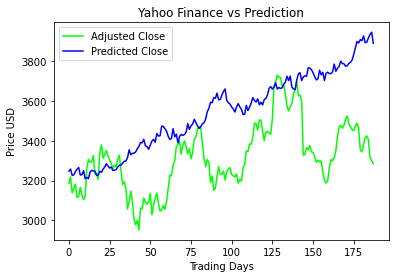

In [261]:

### PLOT SARIMA RESULTS for optimized ###
plot_prediction(df_test_list,predictions_list)

